[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MouseLand/rastermap/blob/main/notebooks/rastermap_zebrafish.ipynb)

# Rastermap sorting of zebrafish neural activity

We will use a zebrafish wholebrain neural activity recording from [Chen*, Mu*, Hu*, Kuan* et al 2018](https://doi.org/10.1016/j.neuron.2018.09.042). The full dataset is available [here](https://doi.org/10.25378/janelia.7272617). The recordings were performed at a rate of 2.1 Hz. We took the neurons with the highest variance signals and deconvolved them to reduce long timescales in the data from the calcium sensor.

First we will install the required packages, if not already installed. If on google colab, it will require you to click the "RESTART RUNTIME" button because we are updating numpy.

In [ ]:
!pip install numpy>=1.24 # (required for google colab)
!pip install rastermap 
!pip install matplotlib

### Load data and import libraries

If not already downloaded, the following cell will automatically download the processed data stored [here](https://osf.io/2w8pa).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# importing rastermap
# (this will be slow the first time since it is compiling the numba functions)
from rastermap import Rastermap, utils
from scipy.stats import zscore

# download spontaneous activity
filename = utils.download_data(data_type="fish")

dat = np.load(filename)

# spks is neurons by time
# (each timepoint is 476 ms)
spks = dat["spks"]

n_neurons, n_time = spks.shape
print(f"{n_neurons} neurons by {n_time} timepoints")

# zscore activity (each neuron activity trace is then mean 0 and standard-deviation 1)
spks = zscore(spks, axis=1)

# XYZ position of each neuron in the recording
xyz = dat["xyz"]

# load the stimulus times
stims = dat["stims"]
# stim colors
fcolor = np.zeros((stims.max()+1, 4))
fcolor[0:3] = np.array([[0., 0.5, 1.0, 1.0], [1.0, 0.0, 1.0, 1.0], 
                        [1., 1., 1., 1.]])
fcolor[8:12] = np.array([[1.0,0.0,0,1],
                        [0.8,1.0,0,1], [0,0,1,1], [0,1,1,1]])

# load the fictive swimming
swimming = dat["swimming"]


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


26370 neurons by 7890 timepoints


In [3]:
print(type(dat))
print(dat.files)

<class 'numpy.lib.npyio.NpzFile'>
['spks', 'xyz', 'stims', 'swimming', 'eyepos']


In [7]:
print(spks.shape)
print(xyz.shape)
print(stims.shape)

print(spks)
print(xyz)
print(stims)

(26370, 7890)
(26370, 3)
(7890,)
[[-0.36324027 -0.36324027  4.6948366  ... -0.36324027 -0.36324027
  -0.36324027]
 [-0.36522314  2.3519692  -0.36522314 ... -0.36522314  6.7012362
  -0.36522314]
 [-0.37536737 -0.37536737 -0.37536737 ...  1.6697562   1.7899861
  -0.15135996]
 ...
 [-0.35923043 -0.35923043 -0.35923043 ...  6.8729444   0.8565977
  -0.35923043]
 [-0.37287298  2.4928722   2.8865545  ... -0.37287298 -0.37287298
  -0.37287298]
 [-0.36771387 -0.36771387 -0.36771387 ... -0.36771387  0.74155927
  -0.36771387]]
[[64967   566    31]
 [64975   554    30]
 [64963   553    29]
 ...
 [65021   258   137]
 [64995   250   137]
 [64985   247   137]]
[2 2 2 ... 3 3 3]


### Run Rastermap

Let's sort the single neurons with Rastermap, with clustering and upsampling:

In [3]:
model = Rastermap(n_clusters=100, # number of clusters to compute
                  n_PCs=200, # number of PCs to use
                  locality=0.1, # locality in sorting is low here to get more global sorting (this is a value from 0-1)
                  time_lag_window=5, # use future timepoints to compute correlation
                  grid_upsample=10, # default value, 10 is good for large recordings
                ).fit(spks)
y = model.embedding # neurons x 1
isort = model.isort

2025-07-31 17:11:25,830 [INFO] normalizing data across axis=1
2025-07-31 17:11:26,274 [INFO] projecting out mean along axis=0
2025-07-31 17:11:26,992 [INFO] data normalized, 1.18sec
2025-07-31 17:11:26,993 [INFO] sorting activity: 26370 valid samples by 7890 timepoints
2025-07-31 17:11:33,989 [INFO] n_PCs = 200 computed, 8.18sec
2025-07-31 17:11:39,465 [INFO] 100 clusters computed, time 13.65sec
2025-07-31 17:11:48,679 [INFO] clusters sorted, time 22.87sec
2025-07-31 17:11:48,991 [INFO] clusters upsampled, time 23.18sec
2025-07-31 17:11:49,317 [INFO] rastermap complete, time 23.51sec


Let's create superneurons from Rastermap -- we sort the data and then sum over neighboring neurons:

In [4]:
nbin = 50 # number of neurons to bin over 
sn = utils.bin1d(spks[isort], bin_size=nbin, axis=0) # bin over neuron axis

### Visualization

Use the Rastermap sorting to visualize the neural activity (see Figure 4 from the paper for the stimulus legend):

(np.float64(-0.5), np.float64(0.5), np.float64(526.5), np.float64(-0.5))

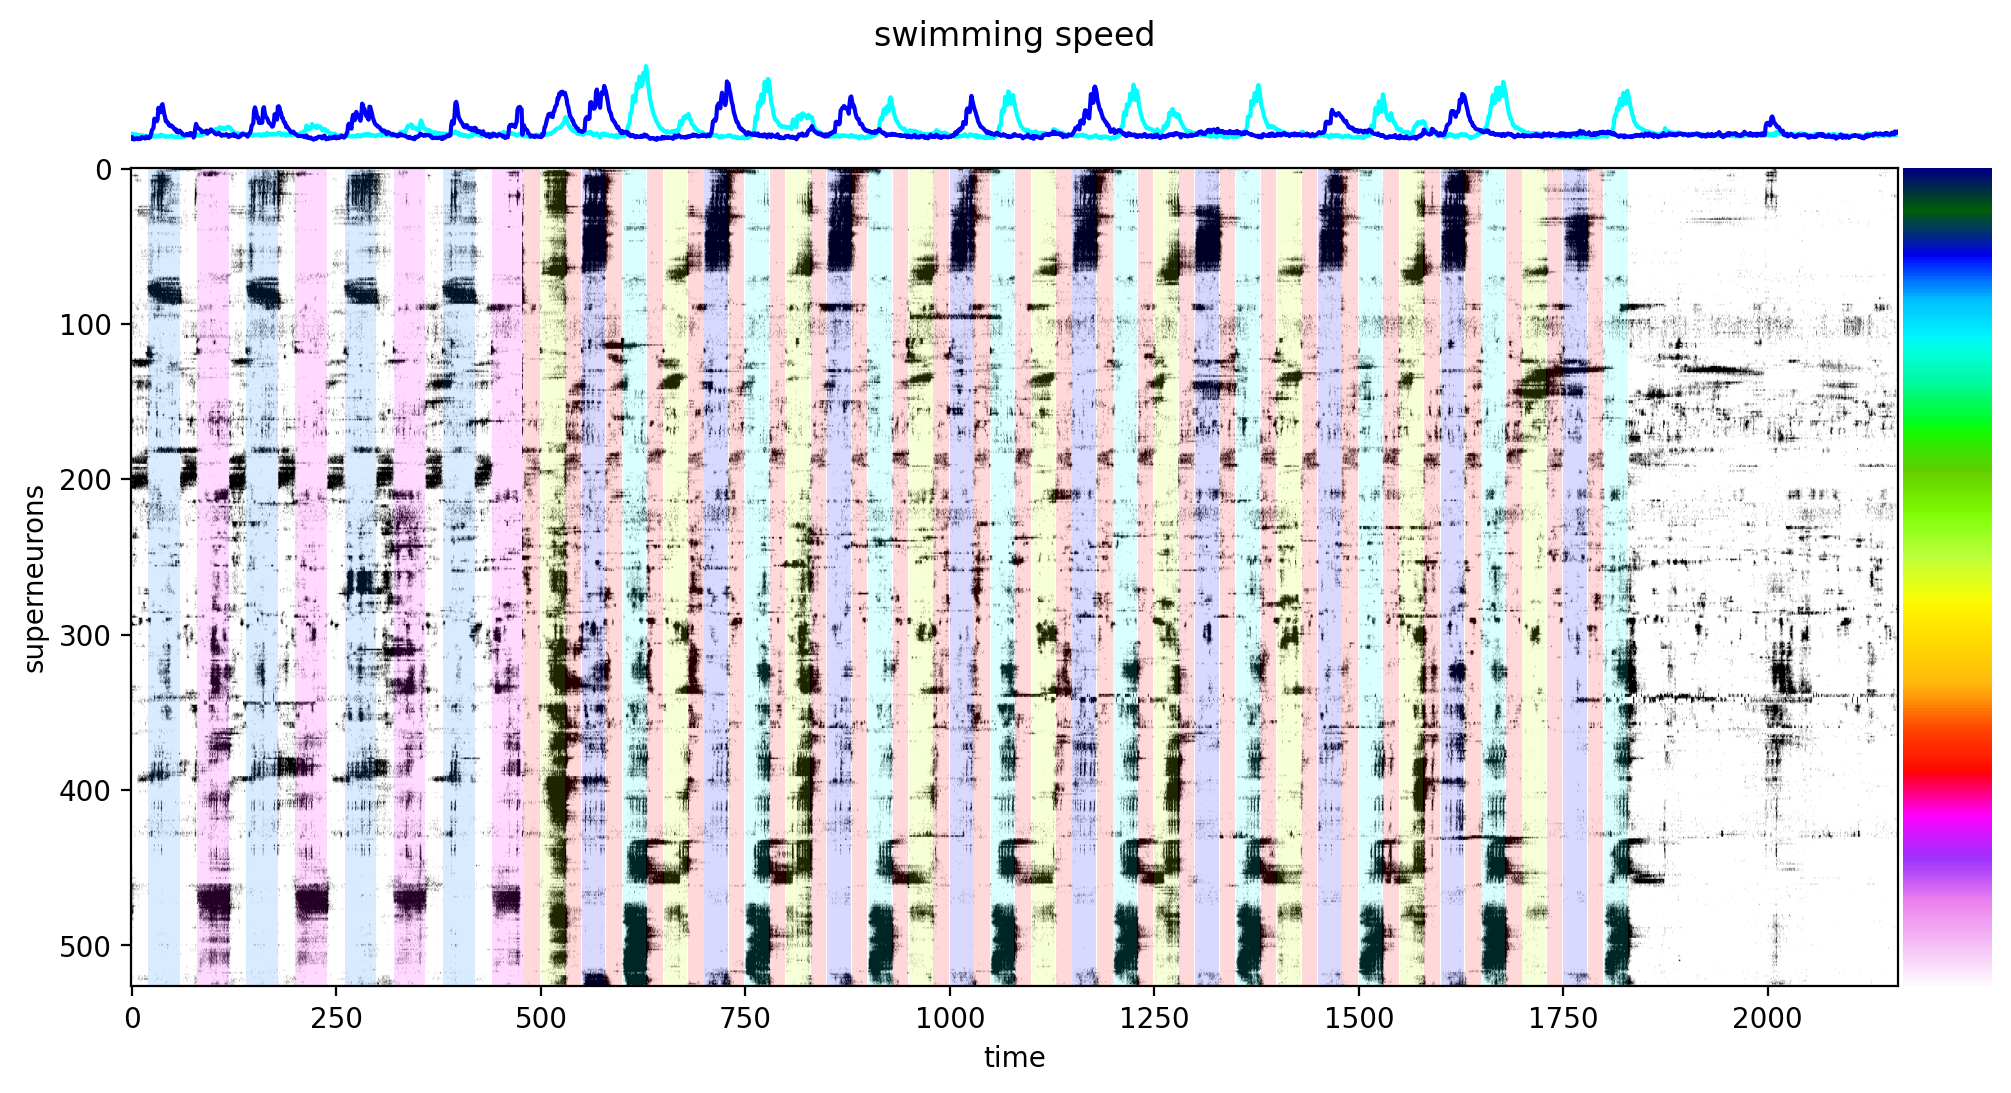

In [5]:
# timepoints to visualize
xmin = 5700
xmax = 7860

# make figure with grid for easy plotting
fig = plt.figure(figsize=(12,6), dpi=200)
grid = plt.GridSpec(9, 20, figure=fig, wspace = 0.05, hspace = 0.3)

# plot swimming speed
ax = plt.subplot(grid[0, :-1])
ax.plot(swimming[xmin:xmax, 0], color=fcolor[11])
ax.plot(swimming[xmin:xmax, 1], color=fcolor[10])
ax.set_xlim([0, xmax-xmin])
ax.axis("off")
ax.set_title("swimming speed")

# plot superneuron activity
ax = plt.subplot(grid[1:, :-1])
ax.imshow(sn[:, xmin:xmax], cmap="gray_r", vmin=0, vmax=0.8, aspect="auto")
ax.set_xlabel("time")
ax.set_ylabel("superneurons")

# color time periods by stimuli
from matplotlib import patches
nn = sn.shape[0]
stims_t = stims[xmin:xmax]
starts = np.nonzero(np.diff(stims_t))
starts = np.append(np.array([0]), starts)
starts = np.append(starts, np.array([len(stims_t)-1]))
for n in range(len(starts)-1):
    start = starts[n]+1
    stype = stims_t[start]
    if stype!=3:
        width = starts[n+1] - start + min(0, start)
        start = max(0, start)
        ax.add_patch(
                patches.Rectangle(xy=(start, 0), width=width,
                            height=nn, facecolor=fcolor[stype], 
                            edgecolor=None, alpha=0.15*(stype!=2)))


ax = plt.subplot(grid[1:, -1])
ax.imshow(np.arange(0, len(sn))[:,np.newaxis], cmap="gist_ncar", aspect="auto")
ax.axis("off")

Color the neurons by their position in the rastermap:

(np.float64(22.9),
 np.float64(1003.0000000000058),
 np.float64(64509.45),
 np.float64(65489.55))

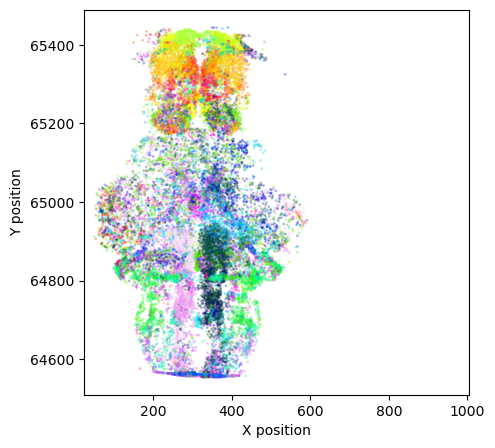

In [6]:
plt.figure(figsize=(5, 5))
plt.scatter(xyz[:,1], xyz[:,0], s=1, c=y, cmap="gist_ncar", alpha=0.25)
plt.xlabel('X position')
plt.ylabel('Y position')
plt.axis("square")

We can also divide the rastermap into sections to more easily visualize spatial relations (as in Figure 4):

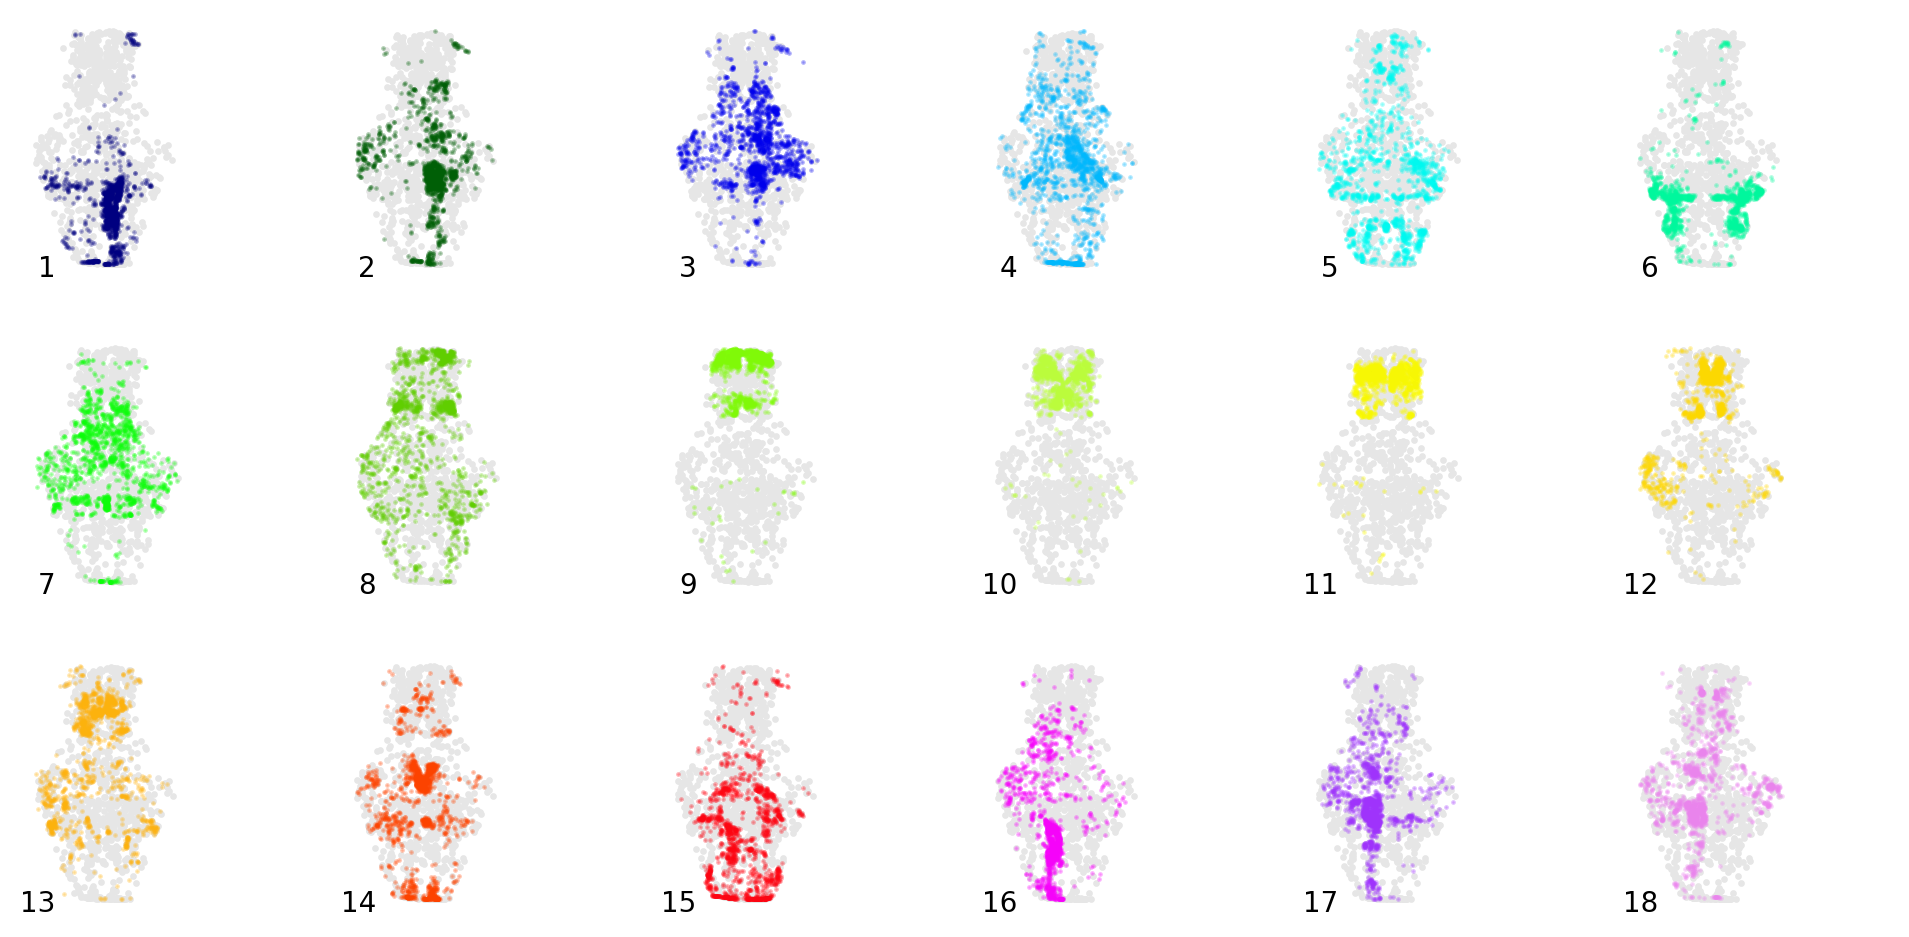

In [7]:
ny, nx = 3, 6
nxy = nx * ny

# divide into nxy sections
nb = len(isort) // nxy
colors = plt.get_cmap("gist_ncar")(np.linspace(0, 0.9, nxy))

# make figure with grid for easy plotting
fig = plt.figure(figsize=(12,6), dpi=200)

grid = plt.GridSpec(ny, nx, figure=fig, wspace = 0.25, hspace = 0.1)
for j in range(nx):
    for k in range(ny):
        ax = plt.subplot(grid[k,j])
        # plot all neurons
        subsample = 25
        ax.scatter(xyz[:,1][::subsample], xyz[:,0][::subsample], s=2, alpha=1, 
                    color=0.9*np.ones(3), rasterized=True)
        ip = j + k*nx
        ix = isort[ip*nb : (ip+1)*nb]
        subsample = 1
        ax.scatter(xyz[ix,1][::subsample], xyz[ix,0][::subsample],
                    s=0.5, alpha=0.3, color=colors[ip])
        ax.axis("off")
        ax.axis("square")
        ax.text(0.1,0,str(ip+1), transform=ax.transAxes, ha="right")

### Settings

You can see all the rastermap settings with `Rastermap?`

In [8]:
Rastermap?

Init signature:
Rastermap(
    n_clusters=100,
    n_PCs=200,
    time_lag_window=0.0,
    locality=0.0,
    grid_upsample=10,
    time_bin=0,
    normalize=True,
    mean_time=True,
    n_splits=0,
    run_scaled_kmeans=True,
    verbose=True,
    verbose_sorting=False,
    keep_norm_X=True,
    bin_size=0,
    symmetric=False,
    random_state=0,
    sticky=True,
    nc_splits=None,
    smoothness=1,
)
Docstring:     
Rastermap embedding algorithm
Rastermap takes the n_PCs (200 default) of the data, and embeds them into
n_clusters clusters. It then sorts the clusters and upsamples to a grid with 
grid_upsample * n_clusters nodes. Each data sample is assigned to a node. 
The assignment of the samples to nodes is attribute `embedding`, and the sorting 
of the nodes is `isort`.

Parameters in order of importance

Parameters
-----------
n_clusters : int, optional (default: 100)
    number of clusters created from data before upsampling and creating embedding
    (any number above 150 wil

### Outputs

All the attributes assigned to the Rastermap `model` are listed with `Rastermap.fit?`

In [9]:
Rastermap.fit?

Signature:
Rastermap.fit(
    self,
    data=None,
    Usv=None,
    Vsv=None,
    U_nodes=None,
    itrain=None,
    compute_X_embedding=True,
    BBt=None,
)
Docstring:
sorts data or singular value decomposition of data by first axis

can use full data matrix, or use singular value decomposition, to reduce RAM 
requirements, it is recommended to use float32. see Rastermap class for 
parameter information (`Rastermap?`)

example usage:
```
import numpy as np
import matplotlib.pyplot as plt
from rastermap import Rastermap, utils
from scipy.stats import zscore

# spks is neurons by time
spks = np.load("spks.npy").astype("float32")
spks = zscore(spks, axis=1)

# fit rastermap
model = Rastermap(n_PCs=200, n_clusters=100, 
                locality=0.75, time_lag_window=5).fit(spks)
y = model.embedding # neurons x 1
isort = model.isort
X_embedding = model.X_embedding # neurons by time

# plot
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111)
ax.imshow(X_embedding, vmin=0, vmax=1.5,